### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from sklearn.datasets import make_classification
from torch.utils.data import Dataset, TensorDataset, DataLoader
import lightkurve as lk
from scipy.optimize import curve_fit
import sys
import utils
import importlib
importlib.reload(utils)


/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils' from '/mnt/c/Users/Lea/OneDrive/TransitClassification_2023/transit_classification/utils.py'>

### Download LC Data

In [ ]:
n_curves = 1000 - len(pd.read_csv('../Data/flux_all_5000_50.csv')) # number of curves to add to the files
n_timesteps = 5000
pct_transits = 50
downsize_method = 'interpolate'
savepath = 'Data'

utils.collect_curves_tofiles(n_curves, n_timesteps, downsize_method, pct_transits, savepath)


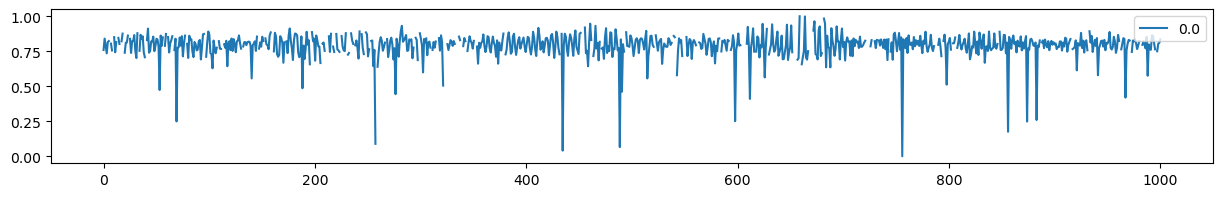

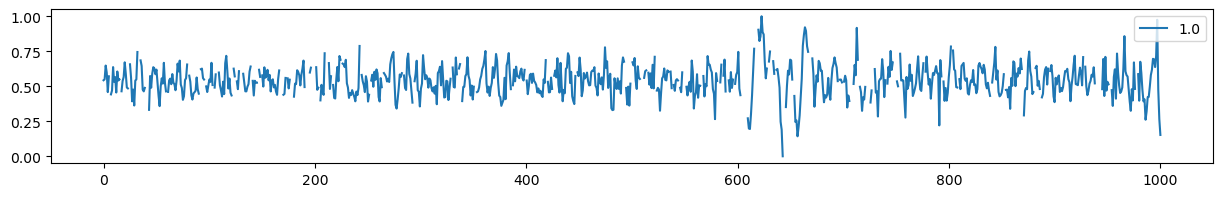

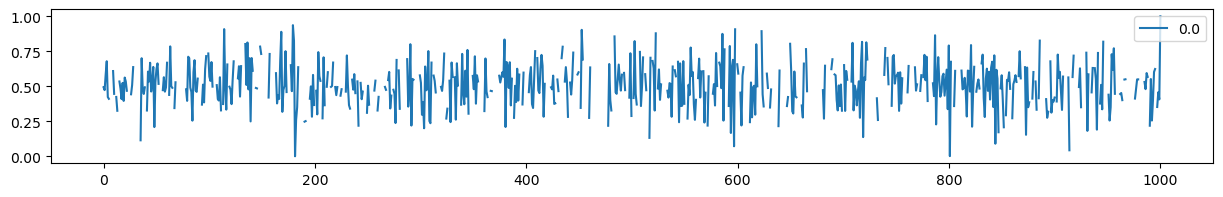

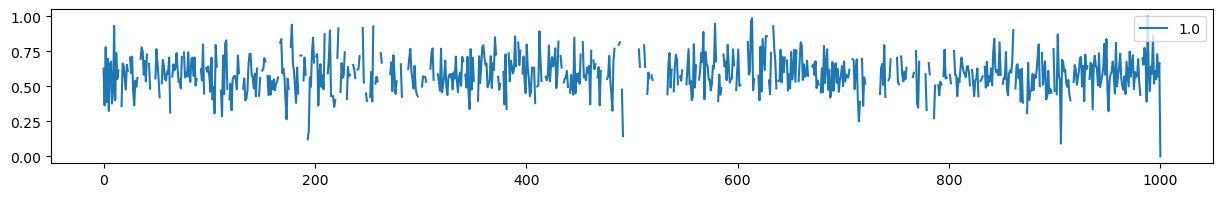

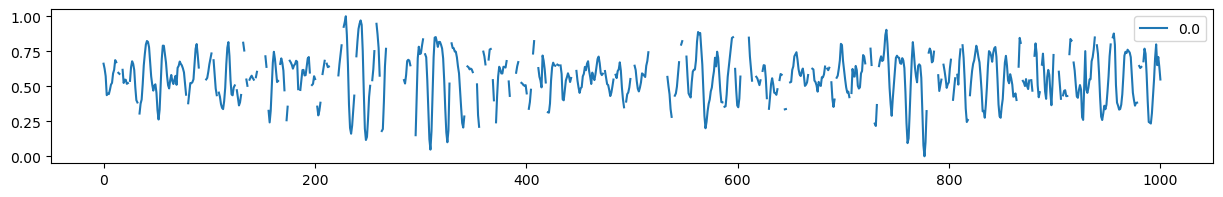

In [14]:
data = pd.read_csv(f"../Data/flux_200_1000_50.csv", header=None)
labels = pd.read_csv(f"../Data/labels_200_1000_50.csv", header=None)
for i in range(5):
    idx = np.random.randint(0, len(labels))
    fluxnorm = ((data.iloc[idx] - np.nanmin(data.iloc[idx]))/(np.nanmax(data.iloc[idx]) - np.nanmin(data.iloc[idx])))
    plt.figure(figsize=(15, 2)); plt.plot(np.linspace(0, 1000, 1000), fluxnorm, label=labels.iloc[i][0]); plt.legend(loc='upper right')

### Implement NN

In [64]:
'''
Try with normal feed-foward NN using fluxes as features
  - This does very poorly
'''

# Load in data and make into train and testloaders
X = pd.read_csv(f"../Data/flux_200_1000_50.csv", header=None).to_numpy() 
Y = pd.read_csv(f"../Data/labels_200_1000_50.csv", header=None).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
batch_size = 3
train_ds = utils.MyDataset(X_train, Y_train, norm=True, impute_nans=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_ds = utils.MyDataset(X_test, Y_test, norm=True, impute_nans=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)
utils.check_inputs(train_ds, train_loader)

input_dim = 1000 # n features (samples not channels?)
n_nodes = [500, 60, 20] # n nodes in hidden layers
output_dim = 2 # n classes

# Define model, loss function and optimizer
model = utils.SimpleNN(input_dim, output_dim, n_nodes)
print(f'Model:\t {model}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Train
epochs = 5
print('Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) # Raw outputs. To get class probs, apply act func. Then argmax to get preds.
    loss = loss_fn(outputs, labels)#.long()) # for CEL, outputs must be float, labels long?
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'\tEpoch {epoch} loss: {running_loss / 2000:.5f}')

# Save the trained NN
torch.save(model.state_dict(), '../NN1.pth')

# Read it back in 
model = utils.SimpleNN(input_dim, output_dim, n_nodes)
model.load_state_dict(torch.load('../NN1.pth'))

# Test 
print('Validating')
accuracy, dice_score = utils.validate(val_loader, model)
print(f"\tGot accuracy {accuracy:.2f}%")

Train data:
     134 obs, broken into 45 batches
     Each batch has data of shape torch.Size([3, 1, 1000]), e.g. 3 obs, 1000 pixels, 1 feature channels
     Each batch has labels of shape torch.Size([3, 2]), e.g. 3 obs, 2 classes
Model:	 SimpleNN(
  (layers): ModuleList(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=60, bias=True)
    (2): Linear(in_features=60, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=2, bias=True)
  )
)
Training
	Epoch 0 loss: 0.01612
	Epoch 1 loss: 0.01568
	Epoch 2 loss: 0.01572
	Epoch 3 loss: 0.01570
	Epoch 4 loss: 0.01570
Validating
	Got accuracy 44.70%


In [30]:
'''
Convolutional (1D) NNs
'''

import utils
import importlib
importlib.reload(utils)

# Load in data and make into train and testloaders
X = pd.read_csv(f"../Data/flux_200_1000_50.csv", header=None).to_numpy() 
Y = pd.read_csv(f"../Data/labels_200_1000_50.csv", header=None).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
batch_size = 5
train_ds = utils.MyDataset(X_train, Y_train, norm=True, impute_nans=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_ds = utils.MyDataset(X_test, Y_test, norm=True, impute_nans=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)
utils.check_inputs(train_ds, train_loader)

input_dim = 1 # n input channels (not samples)
output_dim = 2 # n classes
in_samples = 1000 # n input samples
n_channels = [64, 128, 256] 
n_samples = [2000, 500]

# Define model, loss function and optimizer
model = utils.ConvNN2(input_dim, output_dim, channels=n_channels, in_samps=in_samples, samps=n_samples) #print(f'Model:\n {model}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# Train
epochs = 5
print('Training')
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) # Raw outputs. To get class probs, apply act func. Then argmax to get preds.
    loss = loss_fn(outputs, labels)#.long()) # for CEL, outputs must be float, labels long?
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'\tEpoch {epoch} loss: {running_loss / 2000:.5f}')

# Save the trained NN
torch.save(model.state_dict(), '../NN2.pth')

# Read it back in 
model = utils.ConvNN2(input_dim, output_dim, channels=n_channels, in_samps=n_samples, samps=n_samples)
model.load_state_dict(torch.load('../NN2.pth'))

# Test
print('Validating')
accuracy, dice_score = utils.validate(val_loader, model)
print(f"\tGot accuracy {accuracy:.2f}%")



Train data:
     134 obs, broken into 27 batches
     Each batch has data of shape torch.Size([5, 1, 1000]), e.g. 5 obs, 1000 pixels, 1 feature channels
     Each batch has labels of shape torch.Size([5, 2]), e.g. 5 obs, 2 classes
64000
2000
Training
	Epoch 0 loss: 0.00939
	Epoch 1 loss: 0.00940
	Epoch 2 loss: 0.00942
	Epoch 3 loss: 0.00940
	Epoch 4 loss: 0.00939
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_276/1820899251.py", line 50, in <module>
    model = utils.ConvNN2(input_dim, output_dim, channels=n_channels, in_samps=n_samples, samps=n_samples)
  File "/mnt/c/Users/Lea/OneDrive/TransitClassification_2023/transit_classification/utils.py", line 376, in __init__
    print(int(channels[-1]*in_samps/4))
TypeError: unsupported operand type(s) for /: 'list' and 'int'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/lzucker1/miniconda3/envs/general/lib/python3.10/site-packages/IPython/core/ul

In [ ]:
'''
Other 
    - Try to replicate CNN from Zucker and Giryes (2018) (Still features are just fluxes, no times)
    - Want to be pass in the information about the time of each flux, not just the order - ALTHOUGH LOOKS LIKE PREV WORK DOESNT DO THAT??
    - RNN <----- THIS
    - LSTM: can be used for time-series classification as well time-series prediction (predict next value)
      BUT typically better for long-term trends, which I dont think we actually want - might even pick up unwanted trends.
    - Could also try using both time-series and FT data - for example something like https://www.kaggle.com/code/purplejester/pytorch-deep-time-series-classification
'''